In [ ]:
# Cell 1: Install / upgrade packages (Colab-friendly)
# Run this once at the top. It's silent (quiet) but may print some warnings.
%pip install --upgrade pip setuptools wheel --quiet
%pip install tqdm wordcloud transformers datasets tokenizers scikit-learn matplotlib seaborn nltk --quiet

# Ensure matplotlib works inline (Colab default)
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
# Cell 2: Imports
import os, glob, re, string, json
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

# NLP & ML
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

# Optional transformers (used only if you choose to run HF inference)
try:
    import torch
    from transformers import pipeline
except Exception:
    torch = None

# plotting style
sns.set_style("whitegrid")
plt.rcParams.update({"figure.max_open_warning": 0})

In [ ]:
# === Cell 3: Load your CSV ===
# GANTI path dengan file CSV yang kamu upload di Colab / Drive
csv_path = "raw_link_emirates.csv"
df = pd.read_csv(csv_path)

rename_map={'judul':'title','waktu':'date','konten':'content','kategori':'tag','link':'url'}
for k,v in rename_map.items():
   if k in df.columns: df.rename(columns={k:v}, inplace=True)

# Convert date column to datetime objects
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Quick peek
print("Shape:", df.shape)
display(df.head(5))

Shape: (150, 7)


/tmp/ipython-input-1124581387.py:12: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


,url,domain,year,date,category,title,content
0,https://www.emirates.com/media-centre/the-emir...,www.emirates.com,2014,2014-11-16,Operational,"‘The Emirates App’ now launches on iPhone, ope...","Dubai, UAE, 16 November 2014 – Building on the..."
1,https://www.emirates.com/media-centre/emirates...,www.emirates.com,2015,2015-05-18,Operational,"Emirates expands its mobile footprint, launche...",The Emirates App now available on the world’s ...
2,https://www.emirates.com/media-centre/emirates...,www.emirates.com,2020,2020-03-04,General,Emirates app hits 20 million downloads with st...,"Dubai, UAE, 21 May 2019 – All the features in ..."
3,https://www.emirates.com/media-centre/emirates...,www.emirates.com,2025,2025-04-30,General,Emirates forges partnerships with Internationa...,"Dubai, UAE, 30 April 2025: Emirates has forged..."
4,https://www.executivetraveller.com/emirates-la...,www.executivetraveller.com,2014,2014-11-17,Operational,Emirates launches iPhone app,"Emirates passengers can now book flights, chec..."


In [ ]:
# Cell 4: NLTK resources
# Download semua komponen yang dibutuhkan untuk preprocessing, tokenisasi, dan lemmatization.

import nltk

nltk.download('punkt')                     # tokenisasi dasar
nltk.download('punkt_tab')                 # tambahan untuk word_tokenize
nltk.download('stopwords')                 # daftar stopwords
nltk.download('wordnet')                   # untuk lemmatization
nltk.download('omw-1.4')                   # lemmatization tambahan (WordNet)
nltk.download('averaged_perceptron_tagger')# POS tagging (dipakai di lemmatizer)
nltk.download('averaged_perceptron_tagger_eng') # POS tagging for English

print("✅ NLTK resources downloaded successfully.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...


✅ NLTK resources downloaded successfully.


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
# === Cell 4: Standardize column names (optional) ===
# If your columns are already correct, skip or adjust mapping
desired_cols = ['url','domain','tanggal','judul','konten','tag','category','year']  # example
# lowercase column names
df.columns = [c.strip() for c in df.columns]
print("Columns:", df.columns.tolist())

Columns: ['url', 'domain', 'year', 'date', 'category', 'title', 'content']


In [ ]:
# Cell 5: Text cleaning utilities
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags
         "]+", flags=re.UNICODE)

def remove_emojis(text):
    if pd.isna(text): return ""
    return emoji_pattern.sub(r'', str(text))

def clean_text(text, remove_digits=False):
    if pd.isna(text): return ""
    s = str(text)
    s = remove_emojis(s)
    s = re.sub(r'<[^>]+>', ' ', s)              # remove HTML tags
    s = re.sub(r'http\S+|www\.\S+', ' ', s)     # remove URLs
    if remove_digits:
        s = re.sub(r'\d+', ' ', s)
    # replace punctuation with spaces
    s = s.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

In [ ]:
# Cell 6: Apply cleaning; detect likely text column name; create cleaned columns
# Heuristics: common column names: 'content', 'konten', 'text', 'body', 'article'
candidates = [c for c in df.columns if c.lower() in ('content','konten','text','body','article','konten_clean','article_text','content_clean')]
if len(candidates)==0:
    # try longest text column heuristics
    text_col = max(df.columns.tolist(), key=lambda c: df[c].astype(str).map(len).median())
else:
    text_col = candidates[0]

print("Using text column:", text_col)
df['raw_text'] = df[text_col].astype(str)
df['cleaned_text'] = df['raw_text'].apply(lambda x: clean_text(x, remove_digits=False))
df['cleaned_text'] = df['cleaned_text'].str.lower()

# ensure title & date columns exist if present
title_candidates = [c for c in df.columns if c.lower() in ('title','judul','headline')]
if title_candidates:
    df['title'] = df[title_candidates[0]].astype(str)
else:
    df['title'] = df['raw_text'].str[:120]

date_candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
if date_candidates:
    df['date'] = pd.to_datetime(df[date_candidates[0]], errors='coerce')
else:
    df['date'] = pd.NaT

df['year'] = df['date'].dt.year
display(df[['title','date','year']].head(3))

df['content_raw'] = df['raw_text']
df['content_lower'] = df['cleaned_text']# bikin no-punct/numbers

import re
nopunct = lambda s: re.sub(r'[^a-z\\s]', ' ', s)
df['content_nopunct'] = df['content_lower'].apply(nopunct).str.replace(r'\\s+',' ',regex=True).str.strip()

Using text column: content


,title,date,year
0,"‘The Emirates App’ now launches on iPhone, ope...",2014-11-16,2014.0
1,"Emirates expands its mobile footprint, launche...",2015-05-18,2015.0
2,Emirates app hits 20 million downloads with st...,2020-03-04,2020.0


In [ ]:
# Cell 7: Tokenize (NLTK)
def tokenize(text):
    return word_tokenize(str(text))

tqdm.pandas()
df['tokens_before'] = df['cleaned_text'].progress_apply(tokenize)
df['wc_before'] = df['tokens_before'].apply(len)
df['wc_raw'] = df['content_raw'].str.split().str.len()
df['wc_nopunct'] = df['content_nopunct'].str.split().str.len()

# quick global top tokens (before stopwords)
all_tokens_before = [t.lower() for toks in df['tokens_before'] for t in toks if t.isalpha()]
counter_before = Counter(all_tokens_before)
top20_before = counter_before.most_common(20)
pd.DataFrame(top20_before, columns=['token','freq'])

100%|██████████| 150/150 [00:00<00:00, 345.85it/s]


,token,freq
0,the,5852
1,to,3331
2,and,2983
3,of,2326
4,in,1976
5,a,1872
6,emirates,1438
7,for,1269
8,on,1090
9,s,1078


In [ ]:
# Cell 8: Stopwords (English) and removal
eng_stop = set(stopwords.words('english'))
# add custom stopwords
custom_stop = {"nbsp","www","http","https","com","said"}
stopwords_set = eng_stop.union(custom_stop)

def remove_stopwords(tokens):
    return [t.lower() for t in tokens if t.isalpha() and t.lower() not in stopwords_set and len(t)>1]

df['tokens_after'] = df['tokens_before'].progress_apply(remove_stopwords)
df['wc_after'] = df['tokens_after'].apply(len)
df['text_before_stop'] = df['tokens_before'].apply(lambda toks: " ".join([t for t in toks]))
df['text_after_stop'] = df['tokens_after'].apply(lambda toks: " ".join(toks))

print("Median token counts (before -> after):", df['wc_before'].median(), "->", df['wc_after'].median())
# top tokens after stopwords
all_tokens_after = [t for toks in df['tokens_after'] for t in toks]
counter_after = Counter(all_tokens_after)
pd.DataFrame(counter_after.most_common(30), columns=['token','freq'])

100%|██████████| 150/150 [00:00<00:00, 4357.51it/s]

Median token counts (before -> after): 468.5 -> 272.0


,token,freq
0,emirates,1438
1,uae,547
2,dubai,541
3,airline,537
4,flights,382
5,passengers,345
6,year,344
7,new,342
8,travel,321
9,flight,314


In [ ]:
# Cell 9: Lemmatization (optional; slower but more accurate for some tasks)
# If you prefer lemmas, run this cell (may take longer)
use_lemmatizer = True
if use_lemmatizer:
    lemmatizer = WordNetLemmatizer()
    def nltk_pos_to_wordnet_pos(tag):
        if tag.startswith('J'): return 'a'  # ADJ
        if tag.startswith('V'): return 'v'
        if tag.startswith('N'): return 'n'
        if tag.startswith('R'): return 'r'
        return 'n'
    def lemmatize_tokens(tokens):
        tags = pos_tag(tokens)
        return " ".join(lemmatizer.lemmatize(tok, pos=nltk_pos_to_wordnet_pos(tag)) for tok,tag in tags)
    df['text_lemmatized'] = df['tokens_after'].progress_apply(lemmatize_tokens)
    text_input_col = 'text_lemmatized'
else:
    text_input_col = 'text_stemmed'
print("Using text column for modeling:", text_input_col)

100%|██████████| 150/150 [00:09<00:00, 15.81it/s]

Using text column for modeling: text_lemmatized


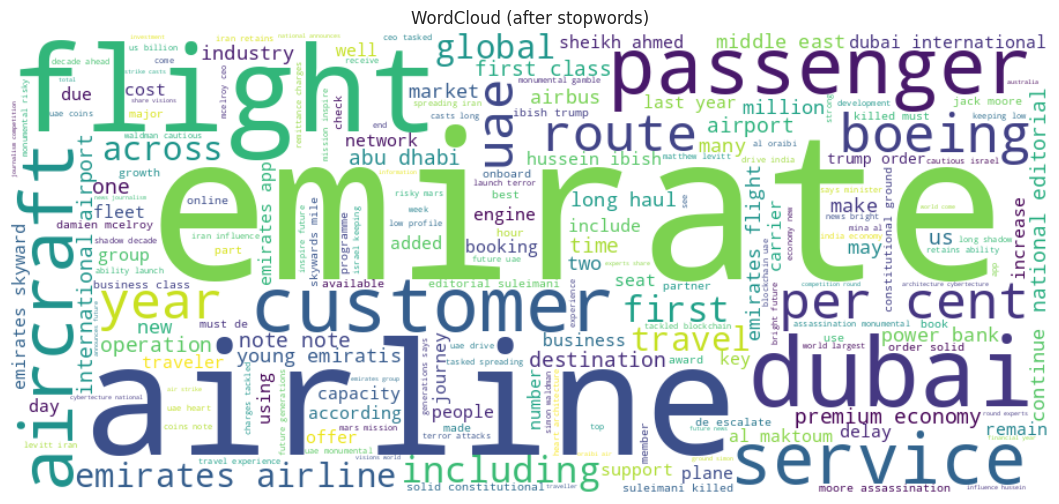

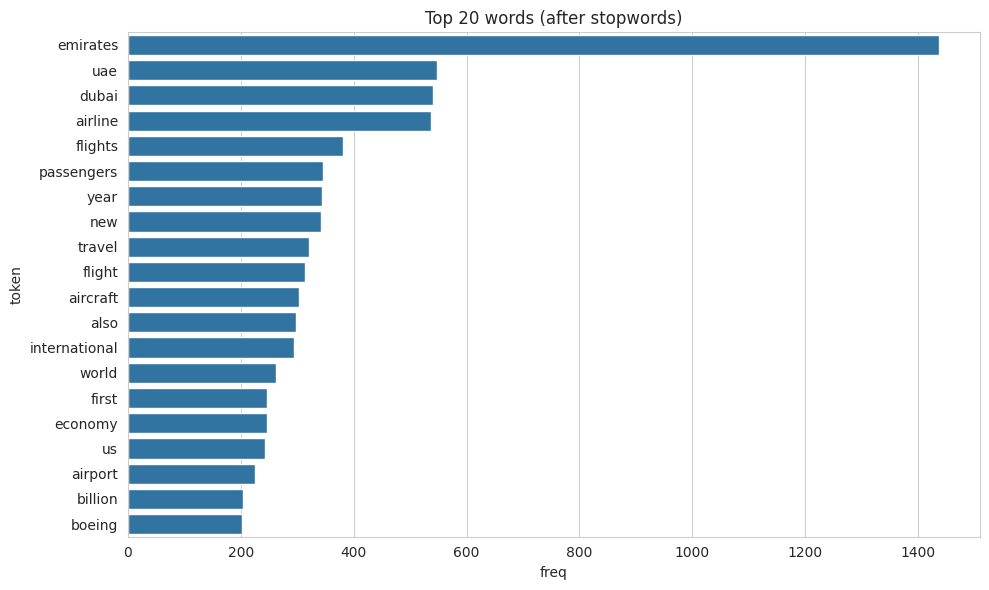

In [ ]:
# Cell 10: WordCloud & top terms plot (from text_after_stop)
#bisa ditambhakan text_lemmetized
corpus = " ".join(df['text_after_stop'].fillna("").astype(str).values)
wc = WordCloud(width=900, height=400, background_color='white').generate(corpus)
plt.figure(figsize=(14,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud (after stopwords)")
plt.show()

# top 20 barplot (stemmed)
top20 = pd.DataFrame(counter_after.most_common(20), columns=['token','freq'])
plt.figure(figsize=(10,6))
sns.barplot(x='freq', y='token', data=top20)
plt.title("Top 20 words (after stopwords)")
plt.tight_layout()
plt.show()

In [ ]:
# Cell 17: Save processed dataset
import os

# Tentukan nama file output
out_csv = "/content/clean_link_emirates.csv"
out_parquet = "/content/clean_link_emirates.parquet"

# Kolom utama yang wajib disimpan untuk tahap berikutnya (TF-IDF, POS, NER, Sentiment)
save_cols = [
    'url','title','date','tag',
    'content_raw','content_lower','content_nopunct',
    'text_before_stop','text_after_stop','text_lemmatized',
    'wc_raw','wc_nopunct','wc_before','wc_after'
]

# Pastikan hanya kolom yang memang ada di DataFrame yang disimpan
save_cols = [c for c in save_cols if c in df.columns]

# Simpan ke CSV dan Parquet (Parquet lebih cepat dibaca di Notebook berikutnya)
df.to_csv(out_csv, columns=save_cols, index=False)
df.to_parquet(out_parquet, index=False)

print("✅ Saved preprocessed dataset:")
print(" - CSV:", out_csv)
print(" - Parquet:", out_parquet)

print("\nDataset siap digunakan untuk tahap TF-IDF, POS, NER, dan Sentiment Analysis.")


✅ Saved preprocessed dataset:
 - CSV: /content/clean_link_emirates.csv
 - Parquet: /content/clean_link_emirates.parquet

Dataset siap digunakan untuk tahap TF-IDF, POS, NER, dan Sentiment Analysis.
